In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('error')

In [ ]:
#@title ellipsoid sampler

def SampleUnitNBall(dim = 3, num = 1):
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample a N-dimensional unit UnitBall
    Reference:
      Efficiently sampling vectors and coordinates from the n-sphere and n-ball
      http://compneuro.uwaterloo.ca/files/publications/voelker.2017.pdf
    Input:
        num - no. of samples
        dim - dimensions
    Output:
        uniformly sampled points within N-dimensional unit ball
    '''
    #Sample on a unit N+1 sphere
    u = np.random.normal(0, 1, (num, dim + 2))
    norm = np.linalg.norm(u, axis = -1,keepdims = True)
    u = u/norm
    #The first N coordinates are uniform in a unit N ball
    if num == 1: return u[0,:dim]
    return u[:,:dim]


class EllipsoidSampler:
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample within a N-dimensional Ellipsoid
    Reference:
      Informed RRT*: Optimal Sampling-based Path Planning Focused via Direct Sampling
      of an Admissible Ellipsoidal Heuristic https://arxiv.org/pdf/1404.2334.pdf
    '''
    def __init__(self, center, axes = [], rot = []):
        '''
        Input:
            center -  centre of the N-dimensional ellipsoid in the N-dimensional
            axes -  axes length across each dimension in ellipsoid frame
            rot - rotation matrix from ellipsoid frame to world frame
        Output:
            uniformly sampled points within the hyperellipsoid
        '''
        self.dim = center.shape[0]
        self.center = center
        self.rot = rot
        if len(rot) == 0: self.rot = np.eye(self.dim)
        if len(axes) == 0: axes = [1]*self.dim
        self.L = np.diag(axes)

    def sample(self,num = 1):
        xball = SampleUnitNBall(self.dim,num)
        #Transform points in UnitBall to ellipsoid
        xellip = (self.rot@self.L@xball.T).T + self.center
        return xellip

class InformedSampler:
    '''
    source: https://gist.github.com/Bharath2/5cfbf21e3c3f75d3a25d06d8a5f22a7d
    uniformly sample within a N-dimensional Prolate-Hyperspheroid for informed RRT*
    with goal and start as focal points
    Reference:
      Informed RRT*: Optimal Sampling-based Path Planning Focused via Direct Sampling
      of an Admissible Ellipsoidal Heuristic https://arxiv.org/pdf/1404.2334.pdf
    '''
    def __init__(self, goal, start):
        self.dim = goal.shape[0]
        self.cmin = np.linalg.norm(goal - start)
        center = (goal + start)/2
        #rotation matrix from ellipsoid frame to world frame
        C = self.RotationToWorldFrame(goal, start)
        #initialise EllipsoidSampler
        self.ellipsampler = EllipsoidSampler(center,rot = C)

    def sample(self, cmax, num = 1):
        '''
        Input:
            cmax - current best cost
            num - no. of samples
        Output:
            uniformly sampled point within informed region
        '''
        #Hyperspheroid axes lengths
        r1 = cmax/2
        ri = np.sqrt(cmax**2 - self.cmin**2)/2
        axes = [r1]+ [ri]*(self.dim - 1)
        self.ellipsampler.L = np.diag(axes)
        #return sampled point
        return self.ellipsampler.sample(num)

    def RotationToWorldFrame(self, goal, start):
        '''
        Given two focal points goal and start in N-Dimensions
        Returns rotation matrix from the ellipsoid frame to the world frame
        '''
        #Transverse axis of the ellipsoid in the world frame
        E1 = (goal - start) / self.cmin
        #first basis vector of the world frame [1,0,0,...]
        W1 = [1]+[0]*(self.dim - 1)
        #outer product of E1 and W1
        M = np.outer(E1,W1)
        #SVD decomposition od outer product
        U, S, V = np.linalg.svd(M)
        #Calculate the middle diagonal matrix
        middleM = np.eye(self.dim)
        middleM[-1,-1] = np.linalg.det(U)*np.linalg.det(V)
        #calculate the rotation matrix
        C = U@middleM@V.T
        return C

In [ ]:
#@title Helper Classes
class Node:
    def __init__(self, tree, coordinates, parent=None, cost=0, children=None):
        self.tree = tree
        self.coordinates = coordinates
        self.parent = parent
        self.cost = cost
        self.children = children if children is not None else []

    def find_nearest(self, coordinates):
        best_node, best_dist = self, coords_dist(self.coordinates, coordinates)
        for child in self.children:
            child_node, child_dist = child.find_nearest(coordinates)
            if best_dist > child_dist:
                best_node, best_dist = child_node, child_dist
        return best_node, best_dist

    def path_to_root(self):
        node = self
        path = [node]
        while node.parent is not None:
            node = node.parent
            path.append(self)
        return path

    def get_neighbors(self, coordinates, radius):
        neighbors = []
        self_dist = coords_dist(self.coordinates, coordinates)
        if self_dist <= radius:
            neighbors.append(self)
        for child in self.children:
            child_neighbors = child.get_neighbors(coordinates, radius)
            neighbors.extend(child_neighbors)
        return neighbors

    def update_cost(self, cost_diff):
        self.cost += cost_diff
        for child in self.children:
            child.update_cost(cost_diff)

    def branch_and_bound(self, rrt_solver):
        for other_tree in rrt_solver.trees:
          if not is_tree_pair_valid(other_tree, self.tree):
            continue
          c_best = rrt_solver.get_c_best(self.tree, other_tree)
          cost_bound = self.cost + other_tree.cost_to_go(self.coordinates)
          if cost_bound <= c_best:
              for child in self.children:
                child.branch_and_bound(rrt_solver)
              return
        self.prune()

    def prune(self):
      self.tree = None
      self.coordinates = None
      if self.parent is not None:
        self.parent.children.remove(self)
      self.parent = None
      for child in self.children:
        child.prune()
      self.children = None


class Tree:
    def __init__(self, tree_type, tree_id, root_source):
        self.tree_type = tree_type  # 'robot'/'goal'
        self.tree_id = tree_id
        self.root = Node(self, root_source)

    def find_nearest(self, coordinates):
        best_node, best_dist = self.root.find_nearest(coordinates)
        return best_node

    def get_neighbors(self, coordinates, radius):
        return self.root.get_neighbors(coordinates, radius)

    def cost_to_go(self, coords):
        return coords_dist(coords, self.root.coordinates)

    def branch_and_bound(self, rrt_solver):
        self.root.branch_and_bound(rrt_solver)

class Connection:
    def __init__(self, node1, node2, check_collision, between_trees=False):
        self.node1 = node1
        self.node2 = node2
        self.check_collision = check_collision
        self.length = coords_dist(node1.coordinates, node2.coordinates)
        if not between_trees:
          self.cost = node1.cost + self.length
        else:
          self.cost = node1.cost + self.length + node2.cost
        self.is_valid = None

    def get_is_valid(self):
        if self.is_valid is None:
            self.is_valid = self.check_collision(self.node1.coordinates, self.node2.coordinates)
        return self.is_valid

In [ ]:
#@title Helper Functions

def coords_dist(coords1, coords2):
    return np.linalg.norm(coords1 - coords2)


def organize_possible_connections(new_node, neighbors, check_collision, between_trees=False):
    possible_connections = []
    for neighbor in neighbors:
        connection = Connection(neighbor, new_node, check_collision, between_trees)
        possible_connections.append(connection)
    possible_connections.sort(key=lambda x: x.cost)
    return possible_connections

def new_choose_parent(new_node, possible_connections, target_tree, c_best):
    for connection in possible_connections:
        if connection.get_is_valid():
            new_node.cost = connection.cost
            new_node.parent = connection.node1
            connection.node1.children.append(new_node)
            return True
    return False

def new_make_children(new_node, possible_connections):
  """
  Rewiring the tree
  """
  for connection in possible_connections:
    neighbor = connection.node1
    # goto new + goto neighbor + neighbor_to_new - goto neighbor < goto neighbor
    if new_node.cost + connection.length < neighbor.cost:
      if connection.get_is_valid():
        old_parent = neighbor.parent
        if old_parent is not None:
          old_parent.children.remove(neighbor)
        neighbor.parent = new_node
        cost_diff = new_node.cost + connection.length - neighbor.cost
        neighbor.update_cost(cost_diff)
        new_node.children.append(neighbor)

def init_trees(robot_sources, goal_sources):
    trees, robot_trees, goal_trees = [], [], []
    count = 0
    for source in robot_sources:
        tree = Tree('robot', count, source)
        robot_trees.append(tree)
        trees.append(tree)
        count += 1
    for source in goal_sources:
        tree = Tree('goal', count, source)
        goal_trees.append(tree)
        trees.append(tree)
        count += 1
    return trees, robot_trees, goal_trees

def is_tree_pair_valid(tree1, tree2):
  return tree1 != tree2 and \
    not (tree1.tree_type == 'robot' and tree2.tree_type == 'robot')

In [ ]:
#@title NewRRTSolver

class NewRRTSolver:
    def __init__(self, robot_sources, goal_sources, bounds, p_task_space,
                 steer_step_size, is_coords_valid, collision_step_size,
                 p_vertex_contraction):
        self.trees, self.robot_trees, self.goal_trees = init_trees(robot_sources, goal_sources)
        self.bounds = bounds
        self.p_task_space = p_task_space
        self.steer_step_size = steer_step_size
        self.tree_connections = {}
        self.is_coords_valid = is_coords_valid
        self.collision_step_size = collision_step_size
        self.p_vertex_contraction = p_vertex_contraction

    def expend_tree(self, expended_tree, target_tree):
        sampled_point = self.sample_point(expended_tree, target_tree)
        nearest_node = expended_tree.find_nearest(sampled_point)
        new_coords = self.steer(nearest_node.coordinates, sampled_point)
        if not self.is_coords_valid(new_coords):
          return
        new_node = Node(expended_tree, new_coords)
        neighbors = expended_tree.get_neighbors(new_coords, self.steer_step_size*2)

        possible_connections = organize_possible_connections(new_node, neighbors, self.check_collision)
        c_best = self.get_c_best(expended_tree, target_tree)
        parent_found = new_choose_parent(new_node, possible_connections, target_tree, c_best)
        if not parent_found:
            return
        new_make_children(new_node, possible_connections)

        self.try_connect_graphs(expended_tree, new_node)
        self.random_vertex_contraction(expended_tree, target_tree)
        self.branch_and_bound(expended_tree)

    def random_expend_tree(self):
        expended_tree, target_tree = self.sample_trees()
        self.expend_tree(expended_tree, target_tree)

    def get_c_best(self, tree1, tree2):
        tree_ids = tuple(sorted((tree1.tree_id, tree2.tree_id)))
        connection = self.tree_connections.get(tree_ids)
        if connection is None:
          return float('inf')
        return connection.cost

    def set_c_best(self, tree1, tree2, c_best, tree_connection):
        tree_ids = tuple(sorted((tree1.tree_id, tree2.tree_id)))
        self.tree_connections[tree_ids] = tree_connection

    def try_connect_graphs(self, expended_tree, new_node):
        for connect_tree in self.trees:
            if not is_tree_pair_valid(expended_tree, connect_tree):
                continue
            c_best = self.get_c_best(expended_tree, connect_tree)
            connection = self.connect_graphs(connect_tree, new_node, c_best)
            if connection is not None:
                self.set_c_best(expended_tree, connect_tree, connection.cost, connection)

    def connect_graphs(self, target_tree, new_node, c_best):
        target_nearest = target_tree.find_nearest(new_node.coordinates)
        target_neighbors = target_tree.get_neighbors(new_node.coordinates, self.steer_step_size*2)
        possible_connections = organize_possible_connections(new_node, target_neighbors, self.check_collision, between_trees=True)

        for connection in possible_connections:
            if connection.cost < c_best and connection.get_is_valid():
                return connection
        return None

    def branch_and_bound(self, expended_tree):
        if self.is_tree_connected(expended_tree):
              expended_tree.branch_and_bound(self)

    def sample_point(self, expended_tree, target_tree):
        p = np.random.rand()
        if p < self.p_task_space:
            return self.sample_task_space(expended_tree, target_tree)
        return self.basic_sample(expended_tree, target_tree)

    def random_vertex_contraction(self, expended_tree, target_tree):
        p = np.random.rand()
        if p > self.p_vertex_contraction:
            return
        tree_ids = tuple(sorted((expended_tree.tree_id, target_tree.tree_id)))
        if not tree_ids in self.tree_connections:
            return
        connection = self.tree_connections[tree_ids]
        leaf = connection.node1 if connection.node1.tree == expended_tree else connection.node2
        path = leaf.path_to_root()
        idx1 = np.random.randint(0, len(path) - 2)
        idx2 = np.random.randint(idx1 + 2, len(path))
        node1 = path[idx1]
        node2 = path[idx2]

        if self.check_collision(node1.coordinates, node2.coordinates):
            cost_diff = node2.cost + coords_dist(node1.coordinates, node2.coordinates) - node1.cost
            node1.update_cost(cost_diff)
            old_parent = node1.parent
            if old_parent is not None:
                old_parent.children.remove(node1)
            node2.children.append(node1)
            node1.parent = node2


    def sample_task_space(self, expended_tree, target_tree):
        closest_node = expended_tree.find_nearest(target_tree.root.coordinates)
        dist = coords_dist(closest_node.coordinates, target_tree.root.coordinates)
        sampler = InformedSampler(closest_node.coordinates, target_tree.root.coordinates)
        # Implement task-space sampling logic
        return sampler.sample(1.2*dist)

    def basic_sample(self, expended_tree, target_tree):
        c_best = self.get_c_best(expended_tree, target_tree)
        if c_best == float('inf'):
            return np.random.uniform(self.bounds[0], self.bounds[1])
        x_goal = target_tree.root.coordinates
        x_start = expended_tree.root.coordinates
        sampler = InformedSampler(x_goal, x_start)

        return sampler.sample(c_best)

    def steer(self, coord1, coord2):
        direction = coord2 - coord1
        distance = np.linalg.norm(direction)
        if distance <= self.steer_step_size:
            return coord2
        try:
            direction /= distance
        except Warning:
            print(direction)
            print(distance)
        return coord1 + direction * self.steer_step_size

    def sample_trees(self):
        expended_tree, target_tree = np.random.choice(self.trees, 2)
        while not is_tree_pair_valid(expended_tree, target_tree):
            expended_tree, target_tree = np.random.choice(self.trees, 2)
        return expended_tree, target_tree

    def is_tree_connected(self, tree):
        for other_tree in self.trees:
            if not is_tree_pair_valid(other_tree, tree):
                continue
            c_best = self.get_c_best(tree, other_tree)
            if c_best == float('inf'):
                return False
        return True

    def check_collision(self, coords1, coords2):
        """
        Checks the path from coords1 to coords2 for collisions in steps of size collision_step_size.

        Parameters:
        coords1 (np.array): Starting coordinates.
        coords2 (np.array): Target coordinates.

        Returns:
        bool: True if the path is collision-free, False if there is a collision.
        """
        # Calculate the direction vector and distance
        direction = coords2 - coords1
        distance = np.linalg.norm(direction)

        # Normalize the direction
        direction /= distance

        # Step along the line from coords1 to coords2, checking each point
        num_steps = int(distance // self.collision_step_size)
        for step in range(num_steps):
            point = coords1 + step * self.collision_step_size * direction
            if not self.is_coords_valid(point):
                return False  # Collision detected at this point

        return True  # Path is collision-free

    def plot_all_trees(self):
        """
        Plots all trees in the solver using matplotlib for a 2D space.
        Each tree is drawn in a unique color with lines connecting nodes.
        """
        plt.figure(figsize=(10, 10))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.trees)))  # Generate unique colors for each tree

        for idx, tree in enumerate(self.trees):
            color = colors[idx]
            print(f"Plotting Tree ID: {tree.tree_id}, Type: {tree.tree_type}")
            x_root, y_root = tree.root.coordinates
            plt.scatter(x_root, y_root, color=color, s=80, marker='D')
            self.plot_tree_nodes(tree.root, color)

        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("Visualization of All Trees in 2D Space")
        # plt.show()

    def plot_tree_nodes(self, node, color):
        """
        Recursively plots each node and its children in a tree.

        Parameters:
        node (Node): The current node being plotted.
        color: Color for plotting the tree.
        """
        x, y = node.coordinates
        plt.scatter(x, y, color=color, s=50)  # Plot the node
        if node.parent:
            px, py = node.parent.coordinates
            plt.plot([px, x], [py, y], color=color, linewidth=1)  # Line from parent to node

        for child in node.children:
            self.plot_tree_nodes(child, color)

    def plot_connections(self):
        for connection in self.tree_connections.values():
            x1, y1 = connection.node1.coordinates
            x2, y2 = connection.node2.coordinates
            plt.plot([x1, x2], [y1, y2], 'black')

In [ ]:
#@title Test ellipsoid sampler
x_start = np.array([0, 0])
x_goal = np.array([100, 50])
c_best = 1.1*np.linalg.norm(x_start-x_goal)
sampler = InformedSampler(x_goal, x_start)
for i in range(1000):
  x = sampler.sample(c_best)
  plt.plot(x[0], x[1], 'bo')

plt.plot(x_start[0], x_start[1], 'ro')
plt.plot(x_goal[0], x_goal[1], 'go')

In [ ]:
bounds = np.array([[0,0],[100,100]])
goal_sources = np.array([[10,10], [10,70], [20,50]])
robot_sources = np.array([[50,50], [40, 30]])
is_coords_valid = lambda x: True
steer_step_size = 1
p_task_space=0.5
p_vertex_contraction=0.1
collision_step_size = 0.1
solver = NewRRTSolver(robot_sources, goal_sources, bounds, p_task_space,
                      steer_step_size, is_coords_valid, collision_step_size,
                      p_vertex_contraction)

In [ ]:
for i in range(100):
  solver.random_expend_tree()

Plotting Tree ID: 0, Type: robot
Plotting Tree ID: 1, Type: robot
Plotting Tree ID: 2, Type: goal
Plotting Tree ID: 3, Type: goal
Plotting Tree ID: 4, Type: goal


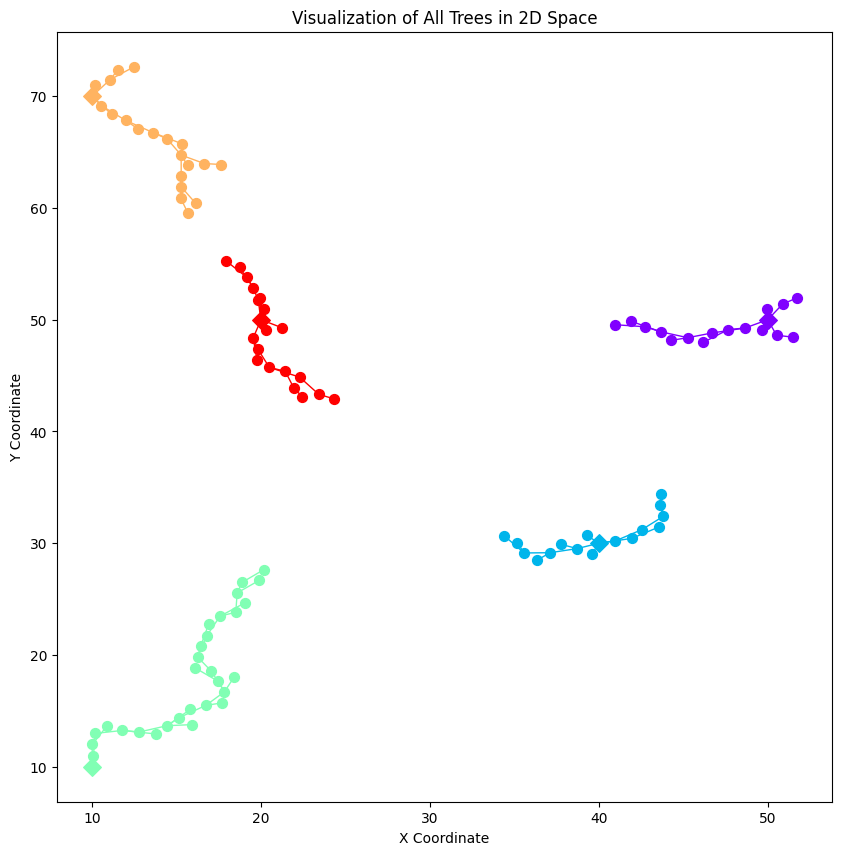

In [ ]:
solver.plot_all_trees()
solver.plot_connections()

# Old Code

In [ ]:
class Node:
  def __init__(self, tree_id, coordinates, parent=None, cost=0, children=[],
               connectors=[]):
    self.tree_id = tree_id
    self.coordinates = coordinates
    self.parent = parent
    self.cost = cost
    self.children = children
    self.connectors = connectors

  def find_nearest(self, coordinates):
    best_node, best_dist = self, coords_dist(self.coordinates, coordinates)
    for child in self.children:
      child_node, child_dist = child.find_nearest(coordinates)
      if best_dist > child_dist:
        best_node, best_dist = child_node, child_dist
    return best_node, best_dist

  def get_neighbors(self, coordinates, radius):
    neighbors = []
    self_dist = coords_dist(self.coordinates, coordinates)
    if self_dist < radius:
      neighbors.append(self)
    for child in self.children:
      child_neighbors = child.get_neighbors(coordinates, radius)
      neighbors.extend(child_neighbors)
    return neighbors

  def update_cost(self, cost_diff):
    self.cost += cost_diff
    for child in self.children:
      child.update_cost(cost_diff)

class Tree:
  def __init__(self, tree_type, tree_id, root):
    self.tree_type = tree_type# 'robot'/'goal'
    self.tree_id = tree_id
    self.root = root

  def find_nearest(self, coordinates):
    best_node, best_dist = self.root.find_nearest(coordinates)
    return best_node

  def get_neighbors(self, coordinates, radius):
    return self.root.get_neighbors(coordinates, radius)

  def cost_to_go(self, coords):
    """The distance of coords from the root"""
    return coords_dist(coords, self.root.coordinates)

class Connection:
  def __init__(self, node1, node2):
    self.node1 = node1
    self.node2 = node2
    self.length = coords_dist(node1.coordinates, node2.coordinates)
    self.cost = node1.cost + self.length # cost of goto node2 trough node 1
    self.is_valid = None

  def get_is_valid(self):
    if is_valid is None:
      self.is_valid = check_collision(self.node1, self.node2)
    return self.is_valid

def coords_dist(coords1, coords2):
  return np.norm(coords1-coords2)

In [ ]:
class NewRRTSolver():
  def __init__(self, robot_sources, goal_sources, bounds, p_task_space,
               steer_step_size, is_coords_valid):
    """
    bounds: [[lower1, lower2, ...], [upper1, upper2, ...]] 2Xd ndarray
    """
    self.trees, self.robot_trees, self.goal_trees = \
      init_trees(robot_sources, goal_sources)
    self.bounds = bounds
    self.p_task_space = p_task_space
    self.steer_step_size = steer_step_size
    self.connection_costs = init_connection_costs(self.trees)
    self.is_coords_valid = is_coords_valid

  def expend_tree(self, expended_tree, target_tree):
    sampled_point = self.sample_point(expended_tree, target_tree)
    nearest_vertex = expended_tree.find_nearest(sampled_point)
    new_coords = steer(nearest_vertex, sampled_point)
    new_vertex = Node(expended_tree.tree_id, new_coords)
    neighbors = expended_tree.get_neighbors(new_coords)

    possible_connections = organize_possible_connections(new_vertex, neighbors)
    c_best = self.get_c_best(expended_tree, target_tree)
    new_choose_parent(new_vertex, possible_connections, target_tree, c_best)

    new_make_children(new_vertex, possible_connections)

    for connect_tree in self.trees:
      if not is_tree_pair_valid(expended_tree, connect_tree):
        continue

      x_connect = connect_tree.find_nearest(new_vertex)
      c_sol, sigma_sol = connect_graphs(connect_tree, x_connect, x_new)
      c_best = self.get_c_best(expended_tree, connect_tree)
      if c_sol is not None and c_sol < c_best:
        c_best = c_sol
        sigma_best = sigma_sol

    p = uniform_sample(0,1)
    if p < self.pVC:
      random_vertex_contraction(sigma_best)
    branch_and_bound(expended_tree, target_tree)

  def get_c_best(self, tree1, tree2):
    return self.connection_costs[sorted((tree1.tree_id, tree2.tree_id))]

  def connect_graphs(target_tree, xi, xf):
    x_new = steer(xi,xf)
    X_near = near(target_tree, x_new)
    L_near = []
    for x_near in X_near:
      sigma_near = steer(x_near, xf)
      c_near = cost(x_near) + cost(sigma_near) + cost(xf)
      L_near.append((c_near, x_near, sigma_near))
    L_near.sort(key=lambda x: x[0])
    for c_near, x_near, sigma_near in L_near:
      if c_near + cost_to_go(x_enar) < c_best:
        if collision_free(sigma_near):
          x_near.connect(xi)
          xi.connect(x_near)
          sigma_connect = generate_path(x_near, xi)
          return c_near, sigma_connect
    return None, None

  def sample_point(self, expended_tree, target_tree):
    p = np.random.rand()
    if p < self.p_task_space:
      return self.sample_task_space()
    return self.basic_sample()

  def sample_trees(self):
    expended_tree, target_tree = np.random.choice(self.trees, 2)
    while not is_tree_pair_valid(expended_tree, target_tree):
      expended_tree, target_tree = np.random.choice(self.trees, 2)
    return expended_tree, target_tree

  def sample_task_space(self):
    self.basic_sample()

  def basic_sample(self):
    return np.random.uniform(self.bounds[0], self.bounds[1])

  def steer(self, coord1, coord2):
    """
    Calc the coordination with steer_step_size from coord1 to coord2
    """
    sub = coord2 - coord1
    dir = sub / np.linalg.norm(sub)
    return coord1 + dir* self.steer_step_size

  def check_collision(self, coord1, coord2):
    return self.is_coords_valid(coord1, coord2)

def organize_possible_connections(new_vertex, neighbors):
  possible_connections = []
  for neighbor in neighbors:
    connection = Connection(neighbor, new_vertex)
    possible_connections.append(connection)
  possible_connections.sort(key=lambda x: x.cost)
  return possible_connections

def new_choose_parent(new_vertex, possible_connections, target_tree, c_best):
  """
  Find a parent for new_vertex from its neighbors.
  Return whether a parent is found.
  """
  for connection in possible_connections:
    neighbor_coords = connection.node1.coordinates
    if connection.cost + target_tree.cost_to_go(neighbor_coords) < c_best:
      if connection.get_is_valid():
        new_vertex.cost = connection.cost
        new_vertex.parent = neighbor
        neighbor.children.append(new_vertex)
        return True
  return False

def new_make_children(new_vertex, possible_connections):
  for connection in possible_connections:
    neighbor = connection.node1
    # goto new + goto neighbor + neighbor_to_new - goto neighbor < goto neighbor
    if new_vertex.cost + connection.length < neighbor.cost:
      if connection.get_is_valid():
        old_parent = neighbor.parent
        if old_parent is not None:
          old_parent.children.remove(neighbor)
        neighbor.parent = new_vertex
        neighbor.cost = new_vertex.cost + connection.length
        new_vertex.children.append(neighbor)

def init_trees(robot_sources, goal_sources):
  trees = []
  robot_trees = []
  goal_trees = []
  count = 0
  for source in robot_sources:
    root = Node(count, source)
    tree = Tree('robot', count, root)
    robot_trees.append(tree)
    trees.append(tree)
    count += 1

  for source in goal_sources:
    root = Node(count, source)
    tree = Tree('goal', count, root)
    goal_trees.append(tree)
    trees.append(tree)
    count += 1
  return trees, robot_trees, goal_trees

def init_connection_costs(trees):
  connection_costs = dict()
  for tree1 in self.trees:
    for tree2 in self.trees:
      if tree1 != tree2:
        connection_costs[sorted((tree1.tree_id, tree2.tree_id))] = float('inf')
  return connection_costs

def is_tree_pair_valid(tree1, tree2):
  return tree1 != tree2 and \
   not (tree1.tree_type == 'robot' or tree2.tree_type == 'robot')